#### INSTALL AND IMPORT DEPENDENCIES

In [13]:
import tensorflow as tf
import cv2,labelme
import shutil
from pathlib import Path
import os,uuid
import matplotlib.pyplot as plt
import time,json,wget
from sklearn.model_selection import train_test_split
import numpy as np,pandas as pd
import albumentations as A
import mediapipe as mp
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score,confusion_matrix
from tensorflow.keras.models import load_model

import os
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from PyPDF2 import PdfMerger


from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

%matplotlib inline

In [4]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord_labelme.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [5]:
PATHS = {
    'workspace':Path('workspace'),
    'images':Path('workspace','images'),
    'train-images':Path('workspace','images','train'),
    'test-images':Path('workspace','images','test'),
    'protoc': Path('workspace','protoc'),
    'scripts': Path('workspace','scripts'),
    'pretrained-model':Path('workspace','pretrained_model'),
    'annotation':Path('workspace','annotation'),
    'models': Path('workspace','models'),
    'CHECKPOINT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'export'),
    'TFJS_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfjsexport'),
    'TFLITE_PATH': Path('workspace','models',CUSTOM_MODEL_NAME,'tfliteexport'),
}


In [6]:
files = {
    'TF_RECORD_SCRIPTS': Path(PATHS['scripts'],TF_RECORD_SCRIPT_NAME),
    'LABELMAP': Path(PATHS['annotation'],LABEL_MAP_NAME),
    'PIPELINE_PATH':os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','pipeline.config'),
    'CHECKPOINT_PATH': os.path.join(str(PATHS['pretrained-model']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','checkpoint')
}

In [8]:
# load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_PATH'])
detection_model = model_builder.build(model_config=configs['model'],is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATHS['CHECKPOINT_PATH'],'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image,shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image,shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

In [9]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
IMAGEFILE_PATH = os.path.join(PATHS['test-images'],'2b11bcd1-881e-11ee-bffd-ec5c68664d70.jpg')

In [10]:

mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def get_angels(results):
        mp_pose = mp.solutions.pose
    # Calculate the wrist
        wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
        index = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX]
        elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
        
        wrist = np.array([wrist.x, wrist.y, wrist.z])
        index = np.array([index.x, index.y, index.z])
        elbow = np.array([elbow.x, elbow.y, elbow.z])

        v1 = index - wrist
        v2 = elbow - wrist
        wrist_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # wrist_angle = np.degrees(wrist_angle)
        if index[1] < wrist[1]:
          wrist_angle = -wrist_angle


        # Calculate the right elbow angle
        shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        elbow = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW]
        wrist = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
        shoulder = np.array([shoulder.x, shoulder.y, shoulder.z])
        elbow = np.array([elbow.x, elbow.y, elbow.z])
        wrist = np.array([wrist.x, wrist.y, wrist.z])
        v1 = shoulder - elbow
        v2 = wrist - elbow
        elbow_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # elbow_angle = np.degrees(elbow_angle)

        # Calculate the right shoulder angle
        hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        hip = np.array([hip.x, hip.y, hip.z])
        v1 = elbow - shoulder
        v2 = hip - shoulder
        shoulder_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # shoulder_angle = np.degrees(shoulder_angle)
        
        # Calculate the hip angle
        knee = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
        knee = np.array([knee.x, knee.y, knee.z])
        v1 = shoulder - hip
        v2 = knee - hip
        hip_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # hip_angle = np.degrees(hip_angle)

        # Calculate the right knee angle
        ankle = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
        ankle = np.array([ankle.x, ankle.y, ankle.z])
        v1 = hip - knee
        v2 = ankle - knee
        knee_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # knee_angle = np.degrees(knee_angle)

        # Calculate the right ankle angle
        heel = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HEEL]
        heel = np.array([heel.x, heel.y, heel.z])
        v1 = knee - ankle
        v2 = heel - ankle
        ankle_angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        # ankle_angle = np.degrees(ankle_angle)

        return [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]


def display_angle_table(frame,results,width,height):
    
    wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle = get_angels(results)

    cv2.rectangle(frame, (width - 600, height - 250), (width, height), (0, 0, 0), cv2.FILLED)
    cv2.line(frame,(width - 600, height - 250), (width - 600, height ), (255,255,255), 4)
    for i in [250,210,170,130,90,50]:
        cv2.line(frame, (width - 600, height - i), (width, height - i), (255,255,255), 4)
    cv2.putText(frame, f'Right wrist angle: {wrist_angle:.2f} degs', (width - 600, height - 220), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Right elbow angle: {elbow_angle:.2f} degs', (width - 600, height - 180), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Right shoulder angle: {shoulder_angle:.2f} degs', (width - 600, height - 140), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Hip angle: {hip_angle:.2f} degs', (width - 600, height - 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Right knee angle: {knee_angle:.2f} degs', (width - 600, height - 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, f'Right ankle angle: {ankle_angle:.2f} degs', (width - 600, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    return [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]


def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    results = model.process(image)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return results

def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(250, 0, 0), thickness=2, circle_radius=2),)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(250, 0, 250), thickness=2, circle_radius=2),)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 121, 255), thickness=2, circle_radius=2),)
    

def extract_keypoint(results):
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

def extract_images(video_path,output_folder,frames_to_extract):
    '''
    extracts images from video
    
    Arguments: 
        video_path: this is the path to the video we are extracting image from
        output_file: this is the directory our extracted image will be saved to
        frame_interval_seconds: this is the seconds interval to save each image
    '''

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_on_save = 0

    Path(output_folder).mkdir(exist_ok=True)
    folder_name = Path(video_path).stem

    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            break

        frame_count += 1
        # current_time_seconds = frame_count / cap.get(cv2.CAP_PROP_FPS)
        # print(current_time_seconds)

        # Save the frame if it's within the desired interval
        if  frame_count in frames_to_extract:

            final_npy_dir = Path(output_folder,folder_name,f"{frame_on_save}.npy")
            image_np = np.array(frame)
        
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            # for i in range(len(detections['detection_boxes'])):
            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            player_frame = image_np[ymin:ymax, xmin:xmax]

            # image,results = mediapipe_detection(player_frame,holistic)

            # print(results)

            # # results_np = extract_keypoint(results)
            # # np.save(results_np,final_npy_dir)
            # # frame_to_save += 1

            output_path = Path(output_folder, f"{str(uuid.uuid1())}.jpg")
            print(output_path)
            cv2.imwrite(str(output_path), player_frame)
    cap.release()

def view_fn(path,starting_point):
    cap = cv2.VideoCapture(path)
    frame_count = 0
    frame_to_save = 0
    folder_name = Path(path).stem
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret,frame = cap.read()
            if not ret:
                break
            
            frame_count += 1
            image_np = np.array(frame)
            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            # for i in range(len(detections['detection_boxes'])):
            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            player_frame = image_np[ymin:ymax, xmin:xmax]
            
            margin = 50

            text_x = max(min(xmin - margin, player_frame.shape[0] - 150), 0)
            text_y = max(min(ymin - margin, player_frame.shape[1] - 150), 0)

            
            if text_x < player_frame.shape[1] and text_y < player_frame.shape[0]:
                cv2.putText(player_frame, f'{frame_count}', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            else:
                print("Text coordinates exceed frame dimensions.")
            cv2.imshow('frame',player_frame)
            

            if frame_count in np.arange(starting_point,starting_point + 25):
                image,results = mediapipe_detection(player_frame,holistic)
                extracted_results = extract_keypoint(results)
                final_npy_dir = Path('shot_detection_images','0',folder_name,f"{frame_to_save}.npy")
                Path('shot_detection_images','0',folder_name).mkdir(exist_ok=True)
                np.save(final_npy_dir,extracted_results)
                draw_landmarks(image,results)
                mp_drawing.draw_landmarks(player_frame, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color=(10, 250, 80), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(250, 0, 0), thickness=2, circle_radius=2),)
                frame_to_save += 1
            elif frame_count > starting_point + 25:
                break

        cap.release()
        cv2.destroyAllWindows()

def create_dataframe(keypoints,name_to_save):
    df = pd.DataFrame(keypoints,columns=['wrist_angle','elbow_angle','shoulder_angle','hip_angle','knee_angle','ankle_angle'])
    df.index = range(1, len(df) + 1)
    df.to_excel(f"{name_to_save}.xlsx")
    

        

In [11]:
def plot_angle_graph_and_save(frames,angles,save_as):

    # Given data
    labels = ["wrist_angle","elbow_angle","shoulder_angle","hip_angle","knee_angle","ankle_angle"]

    df = pd.DataFrame(angles,index=frames,columns=labels)

    # Plotting the data
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)

    plt.xlabel('frame')
    plt.ylabel('angles')
    plt.title('joint flexion angles')
    plt.legend()

    # Show the plot
    plt.savefig(save_as)
    return df

    

1/1 [==============================] - 0s 29ms/step


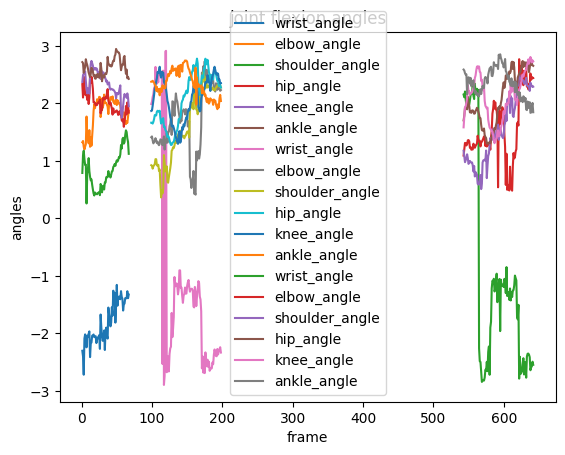

In [14]:
def do_analysis(path):
   cap = cv2.VideoCapture(path)
   width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
   height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
   frame_count = 0
   actions = {0:'noshot',1:'shot'}

   BUFFER_SIZE = 10  # Adjust as needed
   THRESHOLD = 5  # Adjust as needed
   shot_buffer = []

   keypoints_per_frame = []
   player_image_frame = []
   at_shot_frame_num = []
   at_shot_frame_angles = []

   model = load_model('shot_detection_lstm.h5')
   shot_frame_count= 0
   sequences = []
   mp_pose = mp.solutions.pose
   shot_num = 0
   with mp_pose.Pose() as pose:
      while cap.isOpened(): 
            ret, frame = cap.read()

            if not ret:
               create_dataframe(keypoints_per_frame,f"{Path(path).stem}")
               break

            frame_count += 1
            at_shot_frame_num.append(frame_count)
            image_np = np.array(frame)
            fps = cap.get(cv2.CAP_PROP_FPS)

            # Indicate frame number and fps at the top-left corner
            cv2.putText(image_np, f'Frame: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'FPS: {fps:.2f}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'Shot number: {shot_num}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'Shot frame count: {shot_frame_count}', (10, 130), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                        for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

            # Crop the player region and extract mediapip keypoints
            player_frame = image_np[ymin:ymax, xmin:xmax]
            player_image_frame.append(player_frame)
            results = mediapipe_detection(player_frame,holistic)
            keypoints = extract_keypoint(results)

            draw_landmarks(player_frame,results)
            if results.pose_landmarks:
               wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle = display_angle_table(image_np_with_detections,results,width,height)
               item_list = [wrist_angle,elbow_angle,shoulder_angle,hip_angle,knee_angle,ankle_angle]
               at_shot_frame_angles.append(item_list)
               
            sequences.append(keypoints)
            sequence = sequences[-5:]

            if len(sequence) == 5:
               y_predict = model.predict(np.expand_dims(sequence,axis=0))
               y_predict = np.argmax(y_predict)
               shot_label = actions[y_predict]
               shot_buffer.append(shot_label)

               if len(shot_buffer) > BUFFER_SIZE:
                  shot_buffer.pop(0)

               if shot_buffer.count('shot') >= THRESHOLD:
                  shot_frame_count += 1
               else:
                  shot_frame_count = 0
                  player_image_frame = []

               if shot_frame_count == 25:
                  shot_num += 1
                  frames_to_plot = at_shot_frame_num[-100:]
                  angles_to_plot = at_shot_frame_angles[-100:]
                  at_shot_dir = Path('at_shot_image') / Path(path).stem / f"{shot_num}"
                  at_shot_dir.mkdir(parents=True,exist_ok=True)
                  img_path = at_shot_dir / f"{shot_num}.jpg"
                  graph_path = at_shot_dir / f"graph_{shot_num}.png"
                  plot_angle_graph_and_save(frames_to_plot,angles_to_plot,str(graph_path))
                  cv2.imwrite(str(img_path),player_image_frame[0])
                  at_shot_frame_num = []
                  at_shot_frame_angels = []
                  shot_frame_count = 0

            image_np_with_detections[ymin:ymax, xmin:xmax] = player_frame
            cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1200, 600)))

            
            if cv2.waitKey(1) & 0xFF == ord('q'):
               # create_dataframe(keypoints_per_frame,f"{Path(path).stem}")
               cap.release()
               cv2.destroyAllWindows()
               break

do_analysis('videos/CharlieBrownDelaware5Shots.mov')

In [30]:

def create_pdf(pdf_filename, image_paths, folder_name):
    c = canvas.Canvas(pdf_filename, pagesize=letter)

    # Add a header with the folder name
    c.setFont("Helvetica", 12)
    c.drawString(100, 750, f'Shot: #{folder_name}')

    # Draw the first image on the left side
    c.drawImage(image_paths[0], 100, 500, width=200, height=200)

    # Draw the second image on the right side
    c.drawImage(image_paths[1], 320, 500, width=200, height=200)

    c.showPage()
    c.save()

def create_combined_pdf(main_folder, pdf_filename):
    merger = PdfMerger()

    # Iterate through subfolders
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Check if the item in the main folder is a subfolder
        if os.path.isdir(subfolder_path):

            # List image files in the subfolder
            image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Check if there are exactly 2 image files
            if len(image_files) == 2:
                image_paths = [os.path.join(subfolder_path, file) for file in image_files]
                
                # sheet_filename = f'{subfolder}.pdf'
                sheet_filename = os.path.join(subfolder_path,f'{subfolder}.pdf')

                # Create a PDF for each subfolder
                create_pdf(sheet_filename, image_paths, subfolder)
                print(f'PDF created for {subfolder}')

                # Append the sheet to the main PDF
                merger.append(sheet_filename)
            else:
                print(f'Subfolder {subfolder} does not contain 2 images.')

    # Save the final PDF
    merger.write(pdf_filename)
    merger.close()

    # Remove individual subfolder PDFs
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            pdf_path = os.path.join(main_folder,subfolder_path, f'{subfolder}.pdf')
            if os.path.exists(pdf_path):
                os.remove(pdf_path)

    print('PDF creation complete.')

# Example usage
create_combined_pdf('at_shot_image/CharlieBrownDelaware5Shots/', 'at_shot_image/CharlieBrownDelaware5Shots/shot_report.pdf')


PDF created for 1
PDF created for 2
PDF created for 3
PDF created for 4
PDF created for 5
PDF creation complete.


In [42]:
def get_frame_details(path,frame_extract,shot_status='shot'):
    frame_extract = combine_frame_list(frame_extract)
    cap = cv2.VideoCapture(path)
    folder_status = 'shot' if shot_status == 'shot' else 'noshot'
    folder_name = Path('shot_images')/ f"{folder_status}" / Path(path).stem
    folder_numpy = Path('shot_images')/ f"{folder_status}_numpy" / Path(path).stem

    ravel_frame_extract = np.array(frame_extract).ravel()

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = 0

    mp_pose = mp.solutions.pose
    shot_num = 0
    with mp_pose.Pose() as pose:
        while cap.isOpened(): 
            ret, frame = cap.read()
            if not ret:
                break
            
            if frame_count > ravel_frame_extract[-1]:
                break
            frame_count += 1
            image_np = np.array(frame)
            fps = cap.get(cv2.CAP_PROP_FPS)

            # Indicate frame number and fps at the top-left corner
            cv2.putText(image_np, f'Frame: {frame_count}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'FPS: {fps:.2f}', (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image_np, f'Shot number: {shot_num}', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            
            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)
            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                            for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            box = detections['detection_boxes'][0]
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = int(ymin * height), int(xmin * width), int(ymax * height), int(xmax * width)

            cv2.rectangle(image_np_with_detections, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

            # Crop the player region and extract mediapip keypoints
            player_frame = image_np[ymin:ymax, xmin:xmax]
            results = mediapipe_detection(player_frame,holistic)
            keypoints = extract_keypoint(results)
            
            if frame_count in ravel_frame_extract:
                vid_sequence = 0
                for sequence in frame_extract:
                    if frame_count in sequence:
                        shot_dir = Path(folder_name) / f"{vid_sequence}"
                        shot_dir.mkdir(parents=True,exist_ok=True)
                        shot_numpy = Path(folder_numpy) / f"{vid_sequence}"
                        shot_numpy.mkdir(parents=True,exist_ok=True)

                        cv2.imwrite(str(Path(shot_dir)/f"{frame_count}.jpg"),player_frame)
                        np.save(str(Path(shot_numpy)/f"{frame_count}.npy"),keypoints)
                    vid_sequence += 1
            
        
            # draw landmarks on keypoints and display angles on screen
            draw_landmarks(player_frame,results)
            if results.pose_landmarks:
                display_angle_table(image_np_with_detections,results)

            image_np_with_detections[ymin:ymax, xmin:xmax] = player_frame
            cv2.imshow('object detection', cv2.resize(image_np_with_detections, (1200, 600)))

            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                break

def combine_frame_list(items):
    x = []
    for item in items:
        item_arange = np.arange(item,item+5).tolist()
        x.append(item_arange)
    return x


In [40]:
# get_frame_details('videos/CharlieBrownDelaware5Shots.mov',[170,620,1114,1627,2142])
# get_frame_details('videos/CoreyHawkins5Shots.mov',[92,400,714,997,1268])
# get_frame_details('videos/DavonteFitzgerald5Shots.mov',[248,564,906,1192,1495])
# get_frame_details('videos/Elfrid5Shots.mov',[125,446,781,1208,1640])
# get_frame_details('videos/Facu5shots.mov',[120,391,665,998,1315])
# get_frame_details('videos/GregBrown5Shots.mov',[195,627,1076,1592,2124])
# get_frame_details('videos/JaredBrownrigdge5shots.mov',[188,803,1281,1752,2263])
# get_frame_details('videos/JordanWalker5Shots.MOV',[150,579,1045,1462,1890])
# get_frame_details('videos/KylorKelley5Shots.mov',[220,702,1179,1826,2327])
# get_frame_details('videos/Maxi5Shot.mov',[165,571,1115,1608,2070])
# get_frame_details('videos/OMax5Shot.mov',[55,634,1100,1558,2108])
# get_frame_details('videos/SergeIbaka x5.mov',[166,449,718,1014,1381])
# get_frame_details('videos/SteveSir5Shots.mov',[170,605,1144,1663,2102])

In [43]:
# get_frame_details('videos/CharlieBrownDelaware5Shots.mov',[1,90,240,290,350],shot_status='noshot')
# get_frame_details('videos/CoreyHawkins5Shots.mov',[1,58,142,160,180],shot_status='noshot')
# get_frame_details('videos/DavonteFitzgerald5Shots.mov',[1,45,95,210,290],shot_status='noshot')
# get_frame_details('videos/Elfrid5Shots.mov',[1,85,165,180,205],shot_status='noshot')
# get_frame_details('videos/Facu5shots.mov',[1,80,170,235,270],shot_status='noshot')
# get_frame_details('videos/GregBrown5Shots.mov',[1,70,155,300,337],shot_status='noshot')
# get_frame_details('videos/JaredBrownrigdge5shots.mov',[1,100,135,265,320],shot_status='noshot')
# get_frame_details('videos/JordanWalker5Shots.MOV',[1,70,110,230,280],shot_status='noshot')
# get_frame_details('videos/KylorKelley5Shots.mov',[1,160,280,310,340],shot_status='noshot')
# get_frame_details('videos/Maxi5Shot.mov',[1,75,115,260,320],shot_status='noshot')
# get_frame_details('videos/OMax5Shot.mov',[1,15,200,260,325],shot_status='noshot')
# get_frame_details('videos/SergeIbaka x5.mov',[1,15,130,270,300],shot_status='noshot')
# get_frame_details('videos/SteveSir5Shots.mov',[1,160,280,310,340],shot_status='noshot')

#### GET SEQUENCE AND LABELS FOR MODELS

In [44]:
actions = ['noshot','shot']
label_map = {label:num for num,label in enumerate(actions)}
label_map

{'noshot': 0, 'shot': 1}

In [58]:
sequences,labels = [],[]
for action in actions:
    action_path = Path('shot_images') / f"{action}_numpy"
    action_path_dir = [x for x in action_path.glob('*')]
    for player_dir in action_path_dir:
        player_vid_sequence = [x for x in player_dir.glob('*')]
        for vid_sequence in player_vid_sequence:
            files = [np.load(x) for x in vid_sequence.glob('*.npy')]
            sequences.append(files)
            labels.append(label_map[action])

In [59]:
len(sequences)

130

In [60]:
sequences[0]

[array([ 4.05345559e-01,  1.56246677e-01,  1.52761608e-01, ...,
         5.05054355e-01,  3.47891092e-01, -1.91611107e-04]),
 array([ 0.41736901,  0.14443187, -0.08474232, ...,  0.49452993,
         0.34036329, -0.00490887]),
 array([ 0.42430997,  0.14329419, -0.11073017, ...,  0.51390576,
         0.33851627,  0.00606952]),
 array([ 0.42514628,  0.1421883 , -0.01147161, ...,  0.51562226,
         0.34155437, -0.00117965]),
 array([ 0.42122105,  0.14229096,  0.00377664, ...,  0.51022702,
         0.33731213, -0.00425645])]

In [61]:
np.array(labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
sequences,labels = [],[]
for action in actions:
    print(action)
    action_path = Path('shot_detection_images',action)
    action_files = [x for x in action_path.glob('*')]
    for player_file in action_files:
        window = []
        if not player_file.is_dir():
            continue
        for i in range(25):
            image_array = np.load(str(Path(player_file,f"{i}.npy")))
            window.append(image_array)
        sequences.append(window)
        labels.append(label_map[action])
        

noshot
shot


In [64]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [65]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [70]:
x.shape

(130, 5, 1662)

#### BUILD AND TRAIN LSTM NEURAL NETWORK

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import TensorBoard

In [69]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [71]:
model_lstm = Sequential()
model_lstm.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(5,1662)))
model_lstm.add(LSTM(128,return_sequences=True,activation='relu'))
model_lstm.add(LSTM(64,return_sequences=False,activation='relu'))
model_lstm.add(Dense(64,activation='relu'))
model_lstm.add(Dense(32,activation='relu'))
model_lstm.add(Dense(2,activation='softmax'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             442112    
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 596,642
Trainable params: 596,642
Non-trai

In [72]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [73]:
model_lstm.fit(x_train,y_train,epochs=150,callbacks=[tb_callback])

Epoch 1/150
4/4 [==============================] - 19s 52ms/step - loss: 0.6854 - accuracy: 0.7212
Epoch 2/150
4/4 [==============================] - 0s 51ms/step - loss: 0.5842 - accuracy: 0.7500
Epoch 3/150
4/4 [==============================] - 0s 48ms/step - loss: 0.4738 - accuracy: 0.7885
Epoch 4/150
4/4 [==============================] - 0s 42ms/step - loss: 0.4040 - accuracy: 0.8269
Epoch 5/150
4/4 [==============================] - 0s 41ms/step - loss: 0.3141 - accuracy: 0.8654
Epoch 6/150
4/4 [==============================] - 0s 40ms/step - loss: 0.2887 - accuracy: 0.8750
Epoch 7/150
4/4 [==============================] - 0s 40ms/step - loss: 0.2289 - accuracy: 0.8942
Epoch 8/150
4/4 [==============================] - 0s 43ms/step - loss: 0.2252 - accuracy: 0.8942
Epoch 9/150
4/4 [==============================] - 0s 62ms/step - loss: 0.1835 - accuracy: 0.9038
Epoch 10/150
4/4 [==============================] - 0s 48ms/step - loss: 0.1286 - accuracy: 0.9423
Epoch 11/150
4/4 [

In [74]:
x_test.shape

(26, 5, 1662)

In [75]:
y_pred = model_lstm.predict(x_test)

1/1 [==============================] - 1s 1s/step


In [78]:
y_pred_hat = np.argmax(y_pred,axis=1)
y_test_hat = np.argmax(y_test,axis=1)

In [80]:
accuracy_score(y_test_hat,y_pred_hat)

0.8846153846153846

In [81]:
model_lstm.save('shot_detection_lstm.h5')